In [1]:
"""
directory structure

backtracer.ipynb
kabu_plus/
 |- japan-all-stock-data/                            # 07_投資指標データ
    |- daily/
       |- japan-all-stock-data_20210301.csv
       |- *.csv
       ...
 |- japan-all-stock-prices-2/                        # 02_株価一覧表（詳細フォーマット）
    |- daily/
       ...
 |- tosho-stock-ohlc/                                # 06_株価四本値データ（日通し・前場・後場）
    |- daily/
       ... 
 |- japan-all-stock-margin-transactions/             # 10_信用取引残高データ
    |- weekly/
       ... 
"""

base_filepath = 'kabu_plus/'

all_stock_data_filepath = 'japan-all-stock-data/daily/'
japan_all_stock_prices_2_filepath = 'japan-all-stock-prices-2/daily/'
tosho_stock_ohlc_filepath = 'tosho-stock-ohlc/daily/'

japan_all_stock_margin_transactions_filepath = 'japan-all-stock-margin-transactions/weekly/'

In [2]:
import glob
    
def get_all_filename_list(topic_filepath):
    return glob.glob(base_filepath + topic_filepath + "*")

In [111]:
import pandas as pd
from tqdm import tqdm

def create_dataframe_from(file_list):
    df = pd.DataFrame()
    for file in tqdm(file_list):
        try:
            # datetime抜き出し
            # TODO: ここでdatetime型にしちゃうほうがいい
            datetime = int(file.split('.')[0][-8:])
        except:
            print(file + " has failed to be read")
            continue
        df_tmp = pd.read_csv(file, encoding="shift-jis")
        df_tmp['datetime'] = datetime
        df = pd.concat([df, df_tmp])
    return df

def create_sc_datetime_column(file_list):
    def convert_ohlc_dtype(df, key):
        try:
            df[key] = df.apply(lambda x: float(x[key]), 1)
            df[key] = df[key].apply(pd.to_numeric)        
        except:
            pass
        return df
    
    df = create_dataframe_from(file_list)
    print(df)
    df = df.sort_values(by=["datetime", "SC"])

    # datetime dtypeに変換
    df['datetime'] = df.apply(lambda x: datetime.strptime(str(x['datetime']), '%Y%m%d'), 1)

    # library使用のためrename
    df = df.rename(columns={'高値': 'High', '安値': 'Low', '始値': 'Open', '終値': 'Close', '出来高': 'Volume'})
    
    df = convert_ohlc_dtype(df, 'High')
    df = convert_ohlc_dtype(df, 'Low')
    df = convert_ohlc_dtype(df, 'Open')
    df = convert_ohlc_dtype(df, 'Close')
    
    # indexを銘柄+datetimeに変更 (ユニークにする)
    df = df.reset_index()
    df = df.drop(columns=["index"])
    df['SC_datetime'] = df.apply(lambda x: str(x['SC']) + "_" + str(x['datetime']), 1)
    df = df.set_index('SC_datetime')
    return df

In [112]:
file_list = get_all_filename_list(all_stock_data_filepath)

df = create_sc_datetime_column(file_list)

 72%|███████▏  | 191/265 [00:26<00:18,  3.98it/s]

kabu_plus/japan-all-stock-data/daily/japan-all-stock-data.csv has failed to be read


100%|██████████| 265/265 [00:48<00:00,  5.49it/s]


        SC             名称    市場     業種 時価総額（百万円）     発行済株式数 配当利回り（予想）  \
0        1  日経平均株価（日経225）    東証   株価指数         -          -         -   
1        2  TOPIX（東証株価指数）    東証   株価指数         -          -         -   
2     1301             極洋  東証一部  水産・農林     32479   10928283      2.69   
3     1332           日本水産  東証一部  水産・農林    170587  312430277      1.74   
4     1333         マルハニチロ  東証一部  水産・農林    127008   52656910      1.66   
...    ...            ...   ...    ...       ...        ...       ...   
3828  9993           ヤマザワ  東証一部     小売     18524   10960825       1.6   
3829  9994            やまや  東証一部     小売     24733   10847870      2.11   
3830  9995          グローセル  東証一部     卸売     10914   26426800      2.91   
3831  9996          サトー商会   JQS     卸売     13793    9152640      1.99   
3832  9997           ベルーナ  東証一部     小売    105219   97244472      1.76   

     1株配当（予想） PER（予想） PBR（実績） EPS（予想）  BPS（実績）   最低購入額  単元株      高値日付 年初来高値  \
0           -       -       -       -       

In [50]:
file_list = get_all_filename_list(japan_all_stock_prices_2_filepath)

df_prices = create_sc_datetime_column(file_list)

 88%|████████▊ | 233/265 [02:16<00:37,  1.19s/it]

kabu_plus/japan-all-stock-prices-2/daily/japan-all-stock-prices-2.csv has failed to be read


100%|██████████| 265/265 [02:56<00:00,  1.50it/s]


        SC             名称    市場     業種        日付        株価     前日比  前日比（％）  \
0        1  日経平均株価（日経225）    東証   株価指数  20220128  26717.34  547.04    2.09   
1        2  TOPIX（東証株価指数）    東証   株価指数  20220128   1876.89   34.45    1.87   
2     1301             極洋  東証一部  水産・農林  20220128      3095  -15.00   -0.48   
3     1332           日本水産  東証一部  水産・農林  20220128       537    5.00    0.94   
4     1333         マルハニチロ  東証一部  水産・農林  20220128      2426   31.00    1.29   
...    ...            ...   ...    ...       ...       ...     ...     ...   
3879  9993           ヤマザワ  東証一部     小売  20220125      1584  -18.00   -1.12   
3880  9994            やまや  東証一部     小売  20220125      2425   -3.00   -0.12   
3881  9995          グローセル  東証一部     卸売  20220125       410   -2.00   -0.49   
3882  9996          サトー商会   JQS     卸売  20220125      1426    4.00    0.28   
3883  9997           ベルーナ  東証一部     小売  20220125       715  -11.00   -1.52   

         前日終値        始値  ... 時価総額（百万円）  値幅下限  値幅上限      高値日付 年初

,SC,名称,市場,業種,日付,株価,前日比,前日比（％）,前日終値,始値,...,時価総額（百万円）,値幅下限,値幅上限,高値日付,年初来高値,年初来高値乖離率,安値日付,年初来安値,年初来安値乖離率,datetime
SC_datetime,,,,,,,,,,,,,,,,,,,,,
1_20210301,1,日経平均株価（日経225）,東証,株価指数,20210301,29663.5,697.49,2.41,28966.01,29419.45,...,-,-,-,-,-,-,-,-,-,20210301
2_20210301,2,TOPIX（東証株価指数）,東証,株価指数,20210301,1902.48,37.99,2.04,1864.49,1888.61,...,-,-,-,-,-,-,-,-,-,20210301
1301_20210301,1301,極洋,東証一部,水産・農林,20210301,3045,40.00,1.33,3005.0,3005,...,33277,2305,3705,20210208,3160,3.64,20200313,2202,38.28,20210301
1332_20210301,1332,日本水産,東証一部,水産・農林,20210301,518,11.00,2.17,507.0,511,...,161839,407,607,20200107,639,18.94,20200313,398,30.15,20210301
1333_20210301,1333,マルハニチロ,東証一部,水産・農林,20210301,2542,78.00,3.17,2464.0,2484,...,133854,1964,2964,20200117,2780,8.56,20200313,1846,37.7,20210301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993_20220328,9993,ヤマザワ,東証一部,小売,20220328,1619,-11.00,-0.67,1630,1630,...,17746,1230,2030,20210108,1770,8.53,20220309,1551,4.38,20220328
9994_20220328,9994,やまや,東証一部,小売,20220328,2552,-26.00,-1.01,2578,2579,...,27684,2078,3080,20210318,2611,2.26,20210104,2121,20.32,20220328
9995_20220328,9995,グローセル,東証一部,卸売,20220328,440,-1.00,-0.23,441,443,...,11628,361,521,20210127,550,20,20211202,386,13.99,20220328


In [113]:
file_list = get_all_filename_list(tosho_stock_ohlc_filepath)

df_ohlc = create_sc_datetime_column(file_list)

 40%|████      | 107/265 [00:09<00:19,  7.92it/s]

kabu_plus/tosho-stock-ohlc/daily/tosho-stock-ohlc.csv has failed to be read


100%|██████████| 265/265 [00:50<00:00,  5.27it/s]


        SC        日付    始値    高値    安値    終値       VWAP     出来高       売買代金  \
0     1301  20211227  3040  3045  3030  3035  3038.3553    7600   23091500   
1     1332  20211227   541   543   537   537   538.8109  912600  491718800   
2     1333  20211227  2359  2361  2339  2352  2350.2747   81900  192487500   
3     1352  20211227   800   805   800   803      803.9    1000     803900   
4     1375  20211227  1130  1132  1101  1111  1111.0264  280800  311976200   
...    ...       ...   ...   ...   ...   ...        ...     ...        ...   
3743  9993  20211202  1672  1685  1650  1650  1670.2029    6900   11524400   
3744  9994  20211202  2340  2382  2340  2362  2357.0109    9200   21684500   
3745  9995  20211202   396   397   386   386    390.546   61900   24174800   
3746  9996  20211202     -     -     -     -          -       -          -   
3747  9997  20211202   681   692   680   684   686.3258  342900  235341100   

      前場始値  前場高値  前場安値  前場終値  後場始値  後場高値  後場安値  後場終値  datetime 

In [55]:
file_list = get_all_filename_list(japan_all_stock_margin_transactions_filepath)

df_margin = create_sc_datetime_column(file_list)

 64%|██████▍   | 36/56 [00:00<00:00, 61.84it/s]

kabu_plus/japan-all-stock-margin-transactions/weekly/japan-all-stock-margin-transactions.csv has failed to be read


100%|██████████| 56/56 [00:01<00:00, 53.08it/s]


        SC   信用買残高 信用買残高 前週比   信用売残高 信用売残高 前週比   貸借倍率  datetime
0     1301   18700     +5900  114700    +58900   0.16  20210323
1     1332  700500     +2600  746400   +160000   0.94  20210323
2     1333   73500     +5500  196100    +60500   0.37  20210323
3     1352   11200      -300     400         -  28.00  20210323
4     1375  157600    -48800   16800     +2800   9.38  20210323
...    ...     ...       ...     ...       ...    ...       ...
3842  9993    2300      +400    1500      -900   1.53  20211019
3843  9994    4600      +200    8200     -3300   0.56  20211019
3844  9995  206000     +4600    3300     +1300  62.42  20211019
3845  9996    1800      -800       -         -      -  20211019
3846  9997  639900     +3300  282000     -2800   2.27  20211019

[211726 rows x 7 columns]


In [114]:
delete_columns = ['SC', '市場', 'datetime']

# 重複column　の排除
df = pd.merge(df.drop(columns=delete_columns), df_ohlc, left_index=True, right_index=True)
df

,名称,業種,時価総額（百万円）,発行済株式数,配当利回り（予想）,1株配当（予想）,PER（予想）,PBR（実績）,EPS（予想）,BPS（実績）,...,売買代金,前場始値,前場高値,前場安値,前場終値,後場始値,後場高値,後場安値,後場終値,datetime
SC_datetime,,,,,,,,,,,,,,,,,,,,,
1301_2021-03-01 00:00:00,極洋,水産・農林,33277,10928283,2.3,70,10.91,0.85,279.01,3570.06,...,69759000,3005,3045,3005,3035,3040,3060,3025,3045,2021-03-01
1332_2021-03-01 00:00:00,日本水産,水産・農林,161839,312430277,1.64,8.5,14.02,0.98,36.96,529.68,...,776756300,511,514,505,512,512,519,511,518,2021-03-01
1333_2021-03-01 00:00:00,マルハニチロ,水産・農林,133854,52656910,1.57,40,20.9,0.94,121.62,2693.94,...,547659900,2484,2498,2469,2497,2491,2549,2491,2542,2021-03-01
1352_2021-03-01 00:00:00,ホウスイ,卸売,8278,8379000,2.02,20,13.79,1.22,71.65,810.44,...,1673800,988,988,974,974,980,988,980,988,2021-03-01
1375_2021-03-01 00:00:00,雪国まいたけ,水産・農林,72527,39850000,2.31,42,14.22,8.41,127.95,216.31,...,254621100,1769,1797,1768,1794,1793,1824,1791,1820,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993_2022-03-28 00:00:00,ヤマザワ,小売,17746,10960825,1.67,27,35.3,0.61,45.87,2641.08,...,6003600,1630,1642,1619,1619,1618,1619,1615,1619,2022-03-28
9994_2022-03-28 00:00:00,やまや,小売,27684,10847870,1.88,48,6.29,1.02,405.84,2509.49,...,76033700,2579,2580,2563,2563,2565,2568,2550,2552,2022-03-28
9995_2022-03-28 00:00:00,グローセル,卸売,11628,26426800,2.73,12,-,0.5,-23.35,887.37,...,52208700,443,443,441,443,443,444,440,440,2022-03-28


In [115]:
stock_num = 9432

df[df['SC'] == stock_num]

,名称,業種,時価総額（百万円）,発行済株式数,配当利回り（予想）,1株配当（予想）,PER（予想）,PBR（実績）,EPS（予想）,BPS（実績）,...,売買代金,前場始値,前場高値,前場安値,前場終値,後場始値,後場高値,後場安値,後場終値,datetime
SC_datetime,,,,,,,,,,,,,,,,,,,,,
9432_2021-03-01 00:00:00,日本電信電話,情報通信,10969018,3900788940,3.73,105,12.13,1.39,231.84,2025.28,...,15244633500,2800,2816.5,2778.5,2786,2799.5,2812,2788,2812,2021-03-01
9432_2021-03-02 00:00:00,日本電信電話,情報通信,10842243,3900788940,3.78,105,11.99,1.37,231.84,2025.28,...,16747030900,2801,2803,2775,2778.5,2773,2784,2761.5,2779.5,2021-03-02
9432_2021-03-03 00:00:00,日本電信電話,情報通信,10777880,3900788940,3.8,105,11.92,1.36,231.84,2025.28,...,17634703300,2776,2781,2741.5,2761.5,2759.5,2765,2742,2763,2021-03-03
9432_2021-03-04 00:00:00,日本電信電話,情報通信,10617947,3900788940,3.86,105,11.74,1.34,231.84,2025.28,...,23129774050,2663,2720,2663,2697,2714.5,2726,2704.5,2722,2021-03-04
9432_2021-03-05 00:00:00,日本電信電話,情報通信,10772029,3900788940,3.8,105,11.91,1.36,231.84,2025.28,...,17517315950,2700,2732,2700,2723.5,2738.5,2761.5,2728.5,2761.5,2021-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9432_2022-03-22 00:00:00,日本電信電話,情報通信,12959561,3622012656,3.21,115,11.72,1.58,305.42,2258.31,...,24401200300,3528,3578,3525,3563,3577,3593,3570,3578,2022-03-22
9432_2022-03-23 00:00:00,日本電信電話,情報通信,13238456,3622012656,3.15,115,11.97,1.62,305.42,2258.31,...,21185206800,3650,3655,3617,3632,3636,3657,3632,3655,2022-03-23
9432_2022-03-24 00:00:00,日本電信電話,情報通信,13220346,3622012656,3.15,115,11.95,1.62,305.42,2258.31,...,17288030900,3651,3663,3631,3643,3649,3661,3641,3650,2022-03-24


In [116]:
df = df.rename(columns={'高値': 'High', '安値': 'Low', '始値': 'Open', '終値': 'Close', '出来高': 'Volume'})
df.columns

Index(['名称', '業種', '時価総額（百万円）', '発行済株式数', '配当利回り（予想）', '1株配当（予想）', 'PER（予想）',
       'PBR（実績）', 'EPS（予想）', 'BPS（実績）', '最低購入額', '単元株', '高値日付', '年初来高値',
       '安値日付', '年初来安値', 'SC', '日付', 'Open', 'High', 'Low', 'Close', 'VWAP',
       'Volume', '売買代金', '前場始値', '前場高値', '前場安値', '前場終値', '後場始値', '後場高値',
       '後場安値', '後場終値', 'datetime'],
      dtype='object')

In [119]:
from datetime import datetime

df_specific = df[df['SC'] == stock_num]

df_specific = df_specific.reset_index()
df_specific['datetime'] = df_specific.apply(lambda x: datetime.strptime(str(x['datetime']), '%Y-%m-%d %H:%M:%S'), 1)
df_specific = df_specific.set_index('datetime')

In [130]:
df_specific['Open'] = df_specific['Open'].apply(pd.to_numeric)
df_specific['Close'] = df_specific['Close'].apply(pd.to_numeric)        
df_specific['High'] = df_specific['High'].apply(pd.to_numeric)
df_specific['Low'] = df_specific['Low'].apply(pd.to_numeric)
df_specific['Volume'] = df_specific['Volume'].apply(pd.to_numeric)

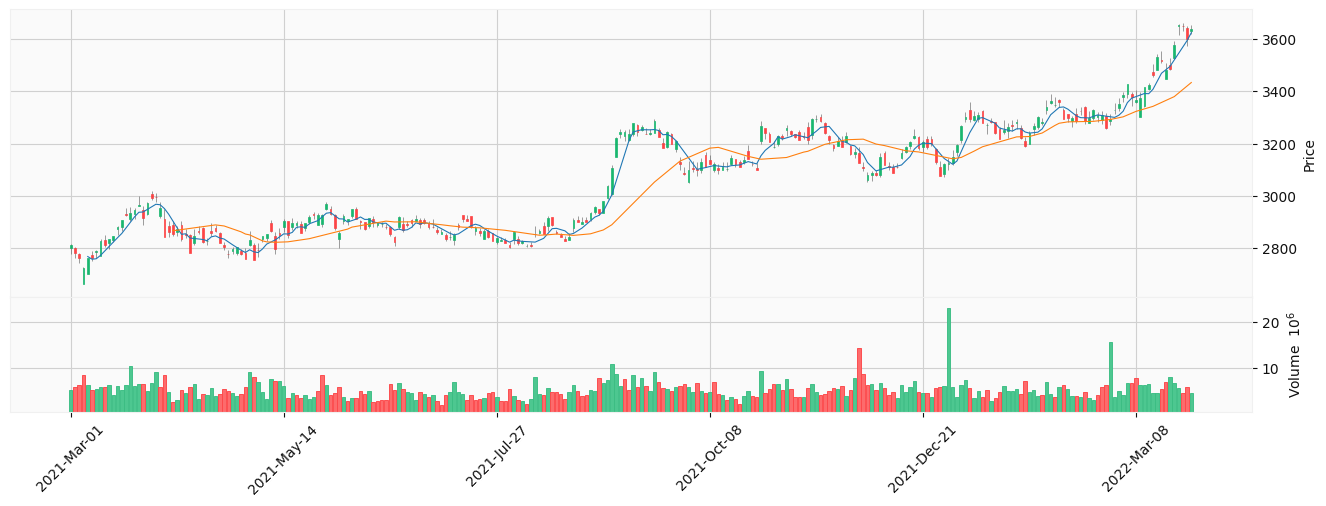

In [131]:
import mplfinance as mpf
mpf.plot(df_specific, type='candle', volume=True, mav=(5, 25), figratio=(12,4), style='yahoo')

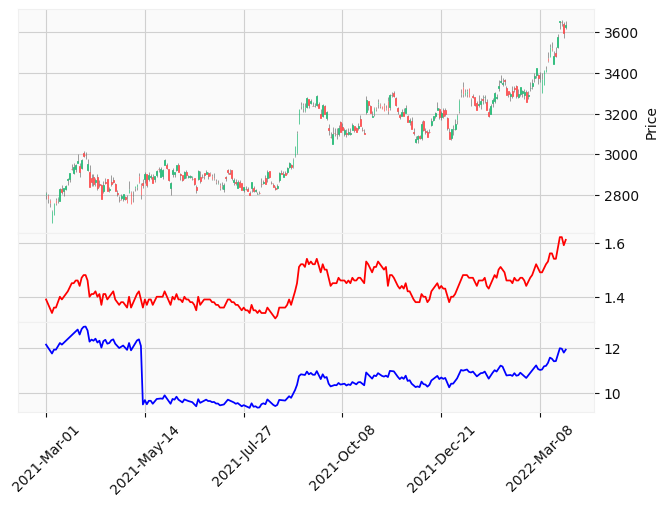

In [140]:
df_specific['PBR（実績）'] = df_specific['PBR（実績）'].apply(pd.to_numeric)
df_specific['PER（予想）'] = df_specific['PER（予想）'].apply(pd.to_numeric)

add_plot_list = [
    mpf.make_addplot(df_specific['PBR（実績）'], color='r', panel=1, secondary_y=False),
    mpf.make_addplot(df_specific['PER（予想）'], color='b', panel=2, secondary_y=False)
]

mpf.plot(df_specific, type='candle', style='yahoo', addplot=add_plot_list)